# Estimación de Masas Nucleares Mediante Redes Neuronales Probabilísticas y Random Forest

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Datos de AME(2020) y NNDC

AME(2020) data: https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt

AME(2020) artículo: https://doi.org/10.1088/1674-1137/abddaf

NNDC: https://www.nndc.bnl.gov/


In [2]:
# Base de datos AME 2020
mass = pd.read_csv("NUBASE1.csv")
mass.columns = ['AAA','ZZZi','AEl', 's', 'Mass', 'dMass']
mass['Mass'] = mass['Mass'].str.replace('#', '.0')
mass['dMass'] = mass['dMass'].str.replace('#', '.0')
mass['ZZZi'] = mass['ZZZi'].astype(str).str[:-1].astype(np.int64)
mass['AAA'] = mass['AAA']
mass = mass.sort_values('ZZZi')
mass = mass.reset_index()
mass = mass.drop('index',axis = 1)
mass = mass.drop('s', axis = 1)
mass

,AAA,ZZZi,AEl,Mass,dMass
0,1,1,1H,7288.971064,1E-05
1,2,1,2H,13135.722895,1E-05
2,3,1,3H,14949.8109,8E-05
3,7,1,7H,49140.0,1000.0
4,4,1,4H,24620,100
...,...,...,...,...,...
5837,293,117,293Ts,194430.0,780.0
5838,294,117,294Ts,196400.0,590.0
5839,294,118,294Og,199320.0,550.0
5840,293,118,293Og,198800.0,710.0


In [3]:
# Energía de primer estado excitado de NNDC
first_ex = pd.read_csv("1st_ExcitedStateEnergy.csv")
first_ex.z = first_ex.z
first_ex.n = first_ex.n
first_ex.columns = ['n','z','First']
first_ex = first_ex.sort_values('z')
first_ex['First'] = first_ex['First']/1000
first_ex

,n,z,First
0,3,1,0.310
1,4,1,3.100
2,5,1,4.100
3,6,1,15.000
4,2,2,20.210
...,...,...,...
2187,158,108,0.085
2188,159,108,0.057
2190,163,110,0.283
2189,160,110,1.130


In [4]:
# Se crea una nueva característica energía del primer estado excitado
mass['FirstExc'] = np.nan

# Se asignan los valores de la energía del primer estado excitado a los correspondientes Z y N

for i in range(len(np.array(first_ex.index))):
    
    A = first_ex.at[i,'z'] + first_ex.at[i,'n']
    FE = first_ex.at[i,'First']
    
    for j in range(len(np.array(mass.index))):
        
        if (first_ex.at[i,'z'] == mass.at[j, 'ZZZi']):
                        
            if (float(A) == float(mass.at[j, 'AAA'])):
                mass.at[j, 'FirstExc'] = FE
                break

        if first_ex.at[i,'z'] < mass.at[j, 'ZZZi']:
            break

In [5]:
# Se incluye el número de neutrones
mass['NNNi'] = mass['AAA']-mass['ZZZi']

In [6]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
mass['DeltaZ']=np.nan
mass['DeltaN']=np.nan
mass['Zshell']=np.nan
mass['Nshell']=np.nan

for i in range(len(np.array(mass.index))):
    
    Z = mass.at[i,'ZZZi']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        mass.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        mass.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        mass.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        mass.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        mass.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        mass.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        mass.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        mass.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = mass.at[i,'NNNi']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        mass.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        mass.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        mass.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        mass.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        mass.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        mass.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        mass.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        mass.at[i,'DeltaN'] = abs(N-126)            

In [7]:
# Se incluye la suma de los nucleones totales por fuera o faltantes en una capa cerrada
mass['DeltaSum'] = mass['DeltaZ'] + mass['DeltaN']

In [8]:
# Se añaden las demás características del modelo de gota líquida
mass['A^2/3']  = mass['AAA']**(2/3)
mass['Z(Z-1)/A^1/3']  = mass['ZZZi']*(mass['ZZZi']-1.0)/mass['AAA']**(1/3)
mass['(N-Z)^2/A']  = (mass['NNNi'] - mass['ZZZi'])**2/mass['AAA']
mass['ZEO'] = np.nan
mass['NEO'] = np.nan

for i in range(len(np.array(mass.index))):

    if (mass.at[i,'ZZZi']%2 == 0):
        mass.at[i,'ZEO']  = 0 
    else:
        mass.at[i,'ZEO']  = 1
        
    if (mass.at[i,'NNNi']%2 == 0):
        mass.at[i,'NEO']  = 0 
    else:
        mass.at[i,'NEO']  = 1

In [9]:
# Se guardan los datos del dataframe con 12 características a implementar
mass = mass.dropna(subset=['Mass'])
mass.reset_index()
mass.to_csv('FULLCHAR.csv', index = False)

In [4]:
massF = pd.read_csv("FULLCHAR.csv")
massF['Mass'] = massF['Mass']/1000
massF

,AAA,ZZZi,AEl,Mass,dMass,FirstExc,NNNi,DeltaZ,DeltaN,Zshell,Nshell,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,1,1,1H,7.288971,0.00001,NaN,0,1.0,0.0,NaN,NaN,1.0,1.000000,0.000000,1.000000,1.0,0.0
1,2,1,2H,13.135723,0.00001,NaN,1,1.0,1.0,NaN,NaN,2.0,1.587401,0.000000,0.000000,1.0,1.0
2,3,1,3H,14.949811,0.00008,NaN,2,1.0,0.0,NaN,NaN,1.0,2.080084,0.000000,0.333333,1.0,0.0
3,7,1,7H,49.140000,1000.00000,15.00,6,1.0,2.0,NaN,NaN,3.0,3.659306,0.000000,3.571429,1.0,0.0
4,4,1,4H,24.620000,100.00000,0.31,3,1.0,1.0,NaN,NaN,2.0,2.519842,0.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,293,117,293Ts,194.430000,780.00000,NaN,176,9.0,50.0,NaN,NaN,59.0,44.114201,2043.405906,11.880546,1.0,0.0
5822,294,117,294Ts,196.400000,590.00000,NaN,177,9.0,51.0,NaN,NaN,60.0,44.214517,2041.086487,12.244898,1.0,1.0
5823,294,118,294Og,199.320000,550.00000,NaN,176,8.0,50.0,NaN,NaN,58.0,44.214517,2076.277633,11.442177,0.0,0.0
5824,293,118,293Og,198.800000,710.00000,NaN,175,8.0,49.0,NaN,NaN,57.0,44.114201,2078.637042,11.088737,0.0,1.0


#### Gráficas del déficit de masa

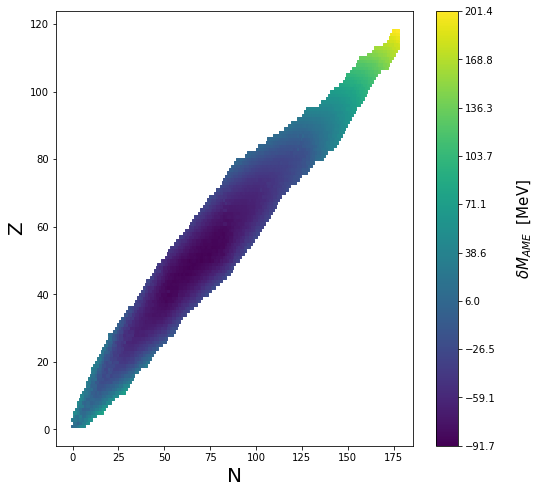

In [11]:
# Gráficas de N,Z vs deficit de mass
%matplotlib inline
fig = plt.figure(figsize = (8,8))
x = massF['NNNi'].to_numpy()
y = massF['ZZZi'].to_numpy()
cmass = massF['Mass'].to_numpy()
plt.scatter(x,y, c = cmass, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

# Función para notación científica
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)

plt.colorbar(ticks=np.linspace(min(cmass),max(cmass),10)).set_label(label='$\delta M_{AME}$  [MeV]', size=15, labelpad=20)
plt.savefig('DeltaMedidas.png',dpi = 500)
plt.show()

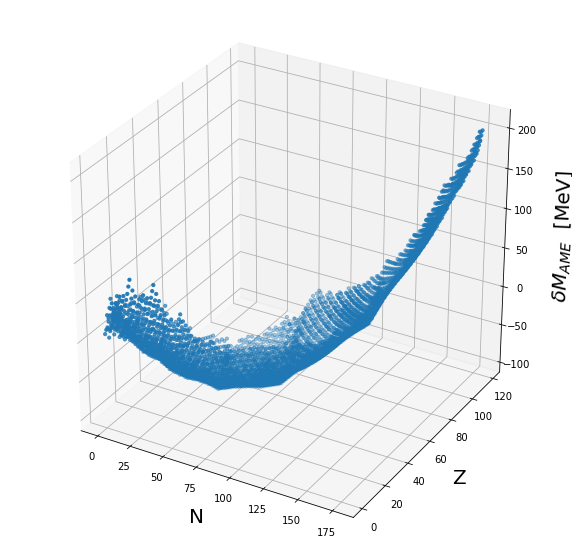

In [5]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plot = plt.figure(figsize=(10,10)).gca(projection='3d')
plot.scatter(np.array(massF['NNNi']), np.array(massF['ZZZi']), np.array(massF['Mass']), s = 10)
plot.set_xlabel('N', fontsize= 20, labelpad=10)
plot.set_ylabel('Z', fontsize= 20, labelpad=10)
plot.set_zlabel('$\delta M_{AME}$  [MeV]', fontsize= 20, labelpad=20)
plt.savefig('DeltaMedidas3D.png',dpi = 500)
plt.show()

#### Energía del primer estado excitado

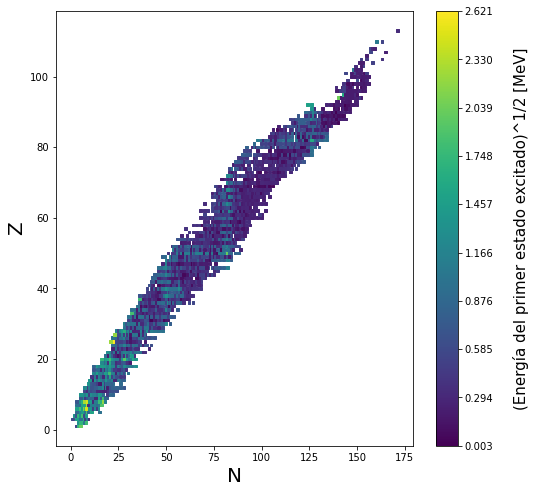

In [13]:
first_excopy = first_ex[first_ex.First != first_ex['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]

nn = first_excopy['n'].to_numpy()
zz = first_excopy['z'].to_numpy()
first = np.sqrt(first_excopy['First'].to_numpy())

fig = plt.figure(figsize = (8,8))
plt.scatter(nn,zz, c = first, s = 7 ,marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(first),max(first),10)).set_label(label='(Energía del primer estado excitado)^1/2 [MeV]', size=15, labelpad=20)
plt.savefig('PrimerEExc.png',dpi = 500)
plt.show()

# SE GRAFICA LA RAÍZ CUADRADA DE LA ENERGÍA DEL PRIMER ESTADO EXCITADO Y SE ELIMINAN (SOLO PARA LA GRÁFICA) 
# LOS TRES VALORES MAYORES CON EL PROPÓSITO DE MOSTRAR MÁS CLARAMENTE LA INFORMACIÓN DE LA ESTRUCTURA QUE ESTA 
#CARACTERÍSTICA POSEE

#### Gráficas de las características $\Delta$N, $\Delta$Z y $\Delta$A = $\Delta$(N+Z)

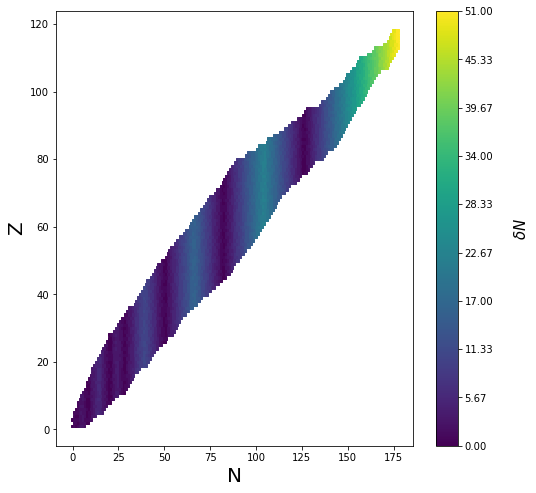

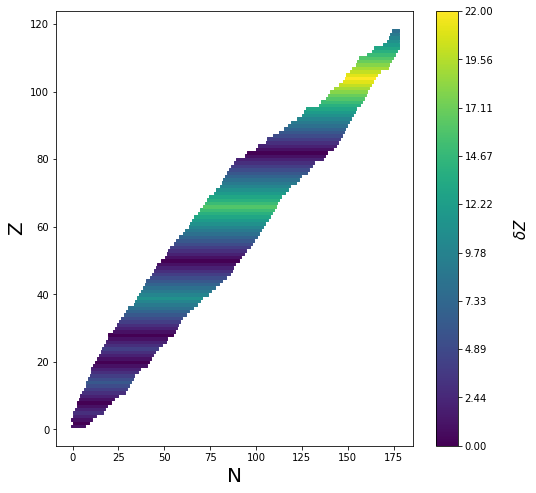

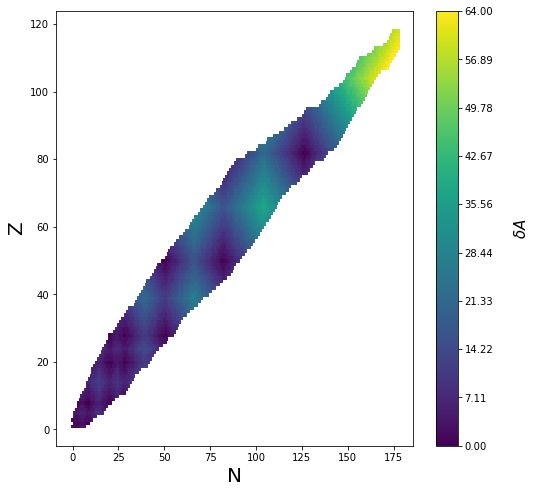

In [14]:
DN = massF['DeltaN'].to_numpy()
DZ = massF['DeltaZ'].to_numpy()
DS = massF['DeltaSum'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DN ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DN),max(DN),10)).set_label(label='$\delta N$', size=15, labelpad=20)
plt.savefig('DeltaN.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DZ ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DZ),max(DZ),10)).set_label(label='$\delta Z$', size=15, labelpad=20)
plt.savefig('DeltaZ.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DS ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(DS),max(DS),10)).set_label(label='$\delta A$', size=15, labelpad=20)
plt.savefig('DeltaS.png',dpi = 500)
plt.show()

#### Gráficas de las características del modelo de gota líquida: términos de superficie, interacción Coulumbiana y asimetría

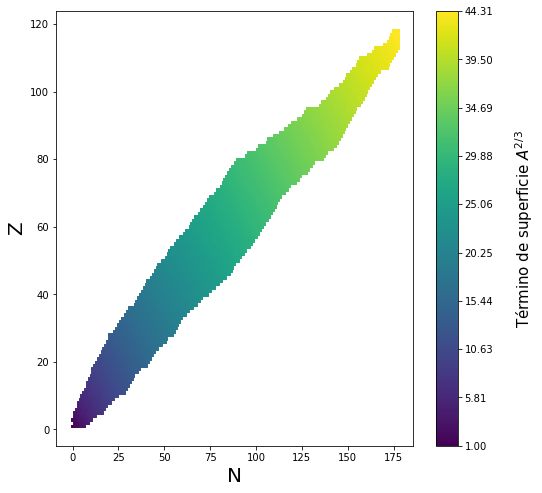

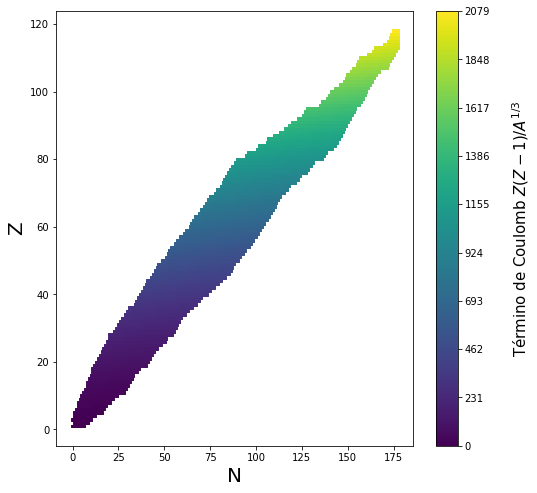

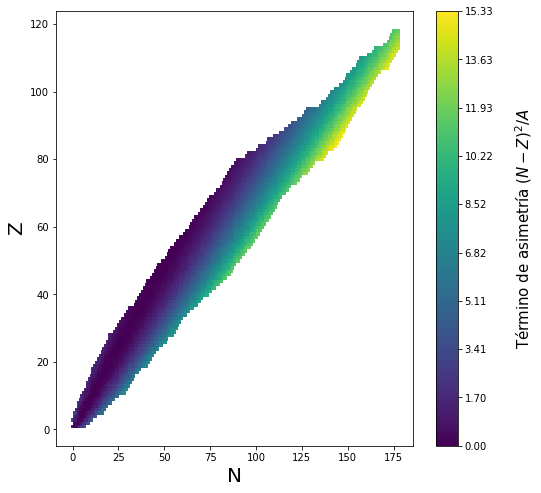

In [15]:
SURF = massF['A^2/3'].to_numpy()
COUL = massF['Z(Z-1)/A^1/3'].to_numpy()
SYMM = massF['(N-Z)^2/A'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SURF ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(SURF),max(SURF),10)).set_label(label='Término de superficie $A^{2/3}$', size=15, labelpad=20)
plt.savefig('A23.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = COUL ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(COUL),max(COUL),10)).set_label(label='Término de Coulomb $Z(Z-1)/A^{1/3}$', size=15, labelpad=20)
plt.savefig('Coulomb.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SYMM ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(SYMM),max(SYMM),10)).set_label(label='Término de asimetría $(N-Z)^2/A$', size=15, labelpad=20)
plt.savefig('Asymm.png',dpi = 500)
plt.show()

In [7]:
# Error raíz cuadrático medio del modelo para calcular la bondad de ajuste
def RMS(Medidas,Prediccion):
    M = np.array(Medidas)
    P = np.array(Prediccion)
    return (sum((M-P)**2)/len(P))**(0.5)  

In [ ]:
# 



# Modelos M12 y M11

## M12
Datos de déficit de masas con 12 características

In [6]:
# Datos M12: Ajuste de déficit de masas con 12 características
massF12 = massF
massF12 = massF12.dropna(subset=['FirstExc'])
massF12 = massF12.dropna(subset=['Mass'])

# Se separan los datos de test y de train
from sklearn.model_selection import train_test_split
massF12train, massF12test, p, q = train_test_split(massF12, massF12['Mass'], test_size=0.2, random_state=42)
    
# Arreglo con los datos. Características por filas y datos por columnas
X12TR = massF12train[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
X12TE = massF12test[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()

# Se normalizan los datos
#X12 = X12.transpose()
#for i in range(X12.shape[0]):
#    X12[i] = (X12[i]-min(X12[i]))/(max(X12[i])-min(X12[i]))
#X12 = X12.transpose()

print('\nDatos de entrenamiento normalizados 12 características:\n\n')
print('X =',X12TR, '\n\n Dimensiones:', X12TR.shape)

# Masas entrenamiento
Y12TR = massF12train['Mass'].to_numpy()
#Y12 = (Y12-min(Y12))/(max(Y12)-min(Y12))
Y12TR = Y12TR.reshape(np.shape(X12TR)[0],-1)
print('\n\nY =',Y12TR, '\n\n Dimensiones:', Y12TR.shape)


print('\nDatos de test normalizados 12 características:\n\n')
print('X =',X12TE, '\n\n Dimensiones:', X12TE.shape)

# Masas test
Y12TE = massF12test['Mass'].to_numpy()
#Y12 = (Y12-min(Y12))/(max(Y12)-min(Y12))
Y12TE = Y12TE.reshape(np.shape(X12TE)[0],-1)
print('\n\nY =',Y12TE, '\n\n Dimensiones:', Y12TE.shape)


Datos de entrenamiento normalizados 12 características:


X = [[ 35.  14.  21. ...   6.   1.   7.]
 [238.  95. 143. ...  13.  17.  30.]
 [156.  61.  95. ...  11.  13.  24.]
 ...
 [133.  55.  78. ...   5.   4.   9.]
 [133.  62.  71. ...  12.  11.  23.]
 [104.  46.  58. ...   4.   8.  12.]] 

 Dimensiones: (1752, 12)


Y = [[-14.39    ]
 [ 48.42    ]
 [-64.1668  ]
 ...
 [-88.070943]
 [-57.11    ]
 [-89.3951  ]] 

 Dimensiones: (1752, 1)

Datos de test normalizados 12 características:


X = [[ 49.  26.  23. ...   2.   3.   5.]
 [ 89.  38.  51. ...  10.   1.  11.]
 [162.  76.  86. ...   6.   4.  10.]
 ...
 [147.  57.  90. ...   7.   8.  15.]
 [135.  54.  81. ...   4.   1.   5.]
 [209.  88. 121. ...   6.   5.  11.]] 

 Dimensiones: (439, 12)


Y = [[-2.4751000e+01]
 [-8.6209030e+01]
 [-1.4500000e+01]
 [-2.9800200e+01]
 [-6.0570000e+01]
 [-3.7820000e+00]
 [-4.9411900e+01]
 [-4.4504000e+01]
 [ 1.6840000e+01]
 [ 3.1290000e+00]
 [-9.8800000e-01]
 [ 1.2416500e+01]
 [-7.0740000e+01]
 [-6.6105000

#### Gráfica de datos de trainig y entrenamiento para el modelo M12

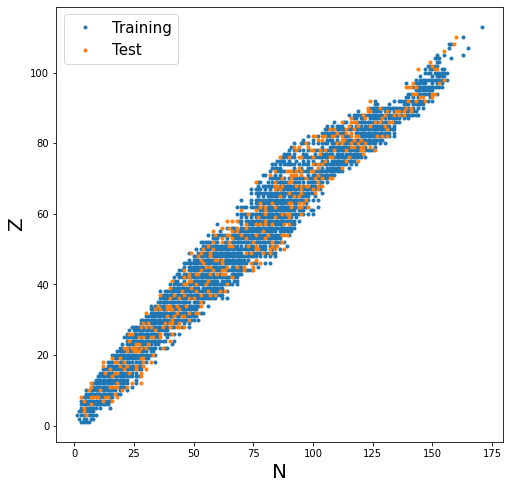

In [18]:
fig = plt.figure(figsize = (8,8))
plt.plot(X12TR[:,2],X12TR[:,1], '.', label = 'Training')
plt.plot(X12TE[:,2],X12TE[:,1], '.', label = 'Test')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M12TT.png',dpi = 500)
plt.show()

## M11
Datos de déficit de masas con 11 características. Eliminando la energía del primer estado excitado

In [7]:
# Datos M11: Ajuste de déficit de masas con 12 características

massF11=massF
massF11 = massF11.drop(columns=['FirstExc'])
massF11 = massF11.dropna(subset=['Mass'])

# Arreglo con los datos. Características por filas y datos por columnas
X11 = massF11[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()

# Se normalizan los datos
#X11 = X11.transpose()
#for i in range(X11.shape[0]):
#    X11[i] = (X11[i]-min(X11[i]))/(max(X11[i])-min(X11[i]))
#X11 = X11.transpose()

print('\nDatos de entrenamiento normalizados 11 características:\n\n')
print('X =',X11, '\n\n Dimensiones:', X11.shape)

# Masas
Y11 = massF11['Mass'].to_numpy()
#Y11 = (Y11-min(Y11))/(max(Y11)-min(Y11))
Y11 = Y11.reshape(5826,-1)
print('\n\nY =',Y11, '\n\n Dimensiones:', Y11.shape)


Datos de entrenamiento normalizados 11 características:


X = [[  1.   1.   0. ...   1.   0.   1.]
 [  2.   1.   1. ...   1.   1.   2.]
 [  3.   1.   2. ...   1.   0.   1.]
 ...
 [294. 118. 176. ...   8.  50.  58.]
 [293. 118. 175. ...   8.  49.  57.]
 [295. 118. 177. ...   8.  51.  59.]] 

 Dimensiones: (5826, 11)


Y = [[  7.28897106]
 [ 13.1357229 ]
 [ 14.9498109 ]
 ...
 [199.32      ]
 [198.8       ]
 [201.37      ]] 

 Dimensiones: (5826, 1)


### Datos de test FRDM(2012) para el modelo M11

FRDM(2012) data: https://t2.lanl.gov/nis/molleretal/publications/ADNDT-FRDM2012.html

FRDM(2012) artículo: https://arxiv.org/pdf/1508.06294.pdf

In [8]:
# Datos de test
test = pd.read_csv('FRDM2012.csv')
test.columns = ['Z','N','A','MthFL']
test

,Z,N,A,MthFL
0,8,8,16,-5.15
1,8,9,17,-1.49
2,8,10,18,-2.81
3,8,11,19,2.15
4,8,12,20,2.19
...,...,...,...,...
9313,135,201,336,349.30
9314,135,202,337,349.90
9315,135,203,338,351.39
9316,135,204,339,352.48


In [21]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
test['DeltaZ']=np.nan
test['DeltaN']=np.nan

for i in range(len(np.array(test.index))):
    
    Z = test.at[i,'Z']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        test.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        test.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        test.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        test.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        test.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        test.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        test.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        test.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = test.at[i,'N']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        test.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        test.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        test.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        test.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        test.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        test.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        test.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        test.at[i,'DeltaN'] = abs(N-126)  
        
test['DeltaSum'] = test['DeltaZ'] + test['DeltaN']

# Se añaden las demás características del modelo de gota líquida
test['A^2/3']  = test['A']**(2/3)
test['Z(Z-1)/A^1/3']  = test['Z']*(test['Z']-1.0)/test['A']**(1/3)
test['(N-Z)^2/A']  = (test['N'] - test['Z'])**2/test['A']
test['ZEO'] = np.nan
test['NEO'] = np.nan

for i in range(len(np.array(test.index))):

    if (test.at[i,'Z']%2 == 0):
        test.at[i,'ZEO']  = 0 
    else:
        test.at[i,'ZEO']  = 1
        
    if (test.at[i,'N']%2 == 0):
        test.at[i,'NEO']  = 0 
    else:
        test.at[i,'NEO']  = 1

In [22]:
# Se guardan los datos de test
test.to_csv('TESTDATAv3.csv', index = False)

In [9]:
# Dataframe con los datos de entrenamiento
Test = pd.read_csv("TESTDATAv3.csv")
Test

,Z,N,A,MthFL,DeltaZ,DeltaN,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,8,8,16,-5.15,0.0,0.0,0.0,6.349604,22.223615,0.000000,0.0,0.0
1,8,9,17,-1.49,0.0,1.0,1.0,6.611489,21.779023,0.058824,0.0,1.0
2,8,10,18,-2.81,0.0,2.0,2.0,6.868285,21.367999,0.222222,0.0,0.0
3,8,11,19,2.15,0.0,3.0,3.0,7.120367,20.986346,0.473684,0.0,1.0
4,8,12,20,2.19,0.0,4.0,4.0,7.368063,20.630576,0.800000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9313,135,201,336,349.30,9.0,75.0,84.0,48.331045,2602.108938,12.964286,1.0,1.0
9314,135,202,337,349.90,9.0,76.0,85.0,48.426892,2599.532590,13.320475,1.0,0.0
9315,135,203,338,351.39,9.0,77.0,86.0,48.522645,2596.966416,13.680473,1.0,1.0
9316,135,204,339,352.48,9.0,78.0,87.0,48.618303,2594.410345,14.044248,1.0,0.0


In [10]:
# Arreglo con los datos. Características por filas y datos por columnas
XT = Test[['A','Z', 'N', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
print('\nDatos de test:\n\n')
print('X =',XT, '\n\n Dimensiones:', XT.shape)
YT = Test['MthFL'].to_numpy()
print('\n\nY =',YT, '\n\n Dimensiones:', YT.shape)


Datos de test:


X = [[ 16.   8.   8. ...   0.   0.   0.]
 [ 17.   8.   9. ...   0.   1.   1.]
 [ 18.   8.  10. ...   0.   2.   2.]
 ...
 [338. 135. 203. ...   9.  77.  86.]
 [339. 135. 204. ...   9.  78.  87.]
 [339. 136. 203. ...  10.  77.  87.]] 

 Dimensiones: (9318, 11)


Y = [ -5.15  -1.49  -2.81 ... 351.39 352.48 358.58] 

 Dimensiones: (9318,)


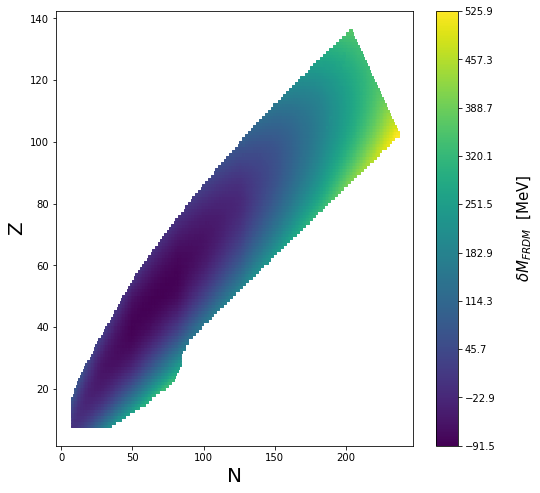

In [25]:
# Gráficas de N,Z vs deficit de mass
fig = plt.figure(figsize = (8,8))
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = np.concatenate((Y11,YT)), marker=',', s=7)
plt.scatter(XT[:,2],XT[:,1], c = YT, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)
plt.colorbar(ticks=np.linspace(min(YT),max(YT),10)).set_label(label='$\delta M_{FRDM}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11Tv3.png',dpi = 500)
plt.show()

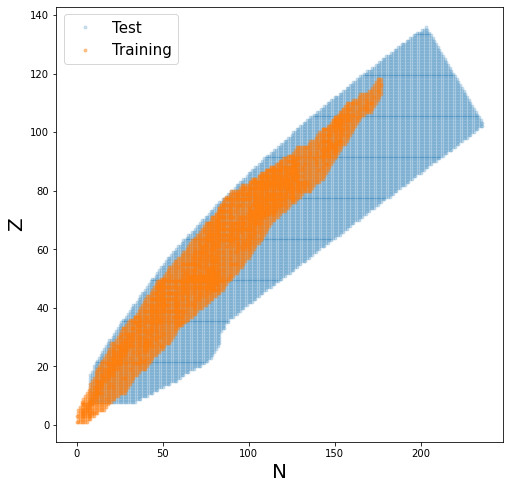

In [26]:
fig = plt.figure(figsize = (8,8))
plt.plot(XT[:,2],XT[:,1], '.', label = 'Test', alpha = 0.2)
plt.plot(X11[:,2],X11[:,1], '.', label = 'Training', alpha = 0.4)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M11TTv3.png',dpi = 500)
plt.show()

# Modelo de Random Forest

# M12

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [28]:
# GridSearch
model12 = RandomForestRegressor()
hyperparam = {'n_estimators':[2000,2050]}
fitter = GridSearchCV(model12, hyperparam)

In [29]:
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
fitter.fit(X12TR,Y12TR1)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [2000, 2050]})

In [30]:
fitter.best_params_

{'n_estimators': 2050}

In [31]:
# Se entrena el modelo
model12 = RandomForestRegressor(n_estimators= 2000)
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
model12.fit(X12TR,Y12TR1)

RandomForestRegressor(n_estimators=2000)

In [32]:
print("Coeficiente de determinación del modelo para los datos de training: ",model12.score(X12TR, Y12TR))
print("Coeficiente de determinación del modelo para los datos de test: ",model12.score(X12TE, Y12TE))

Coeficiente de determinación del modelo para los datos de training:  0.9991275831919519
Coeficiente de determinación del modelo para los datos de test:  0.9928776336836058


In [33]:
FULLDATA12 = np.concatenate((X12TR,X12TE))
FULLDATAY = np.concatenate((Y12TR,Y12TE))
FULLDATAY = FULLDATAY.reshape(2191,)
PRED = model12.predict(FULLDATA12)

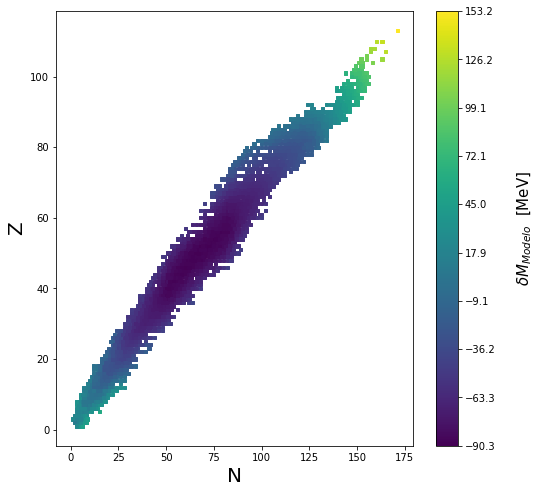

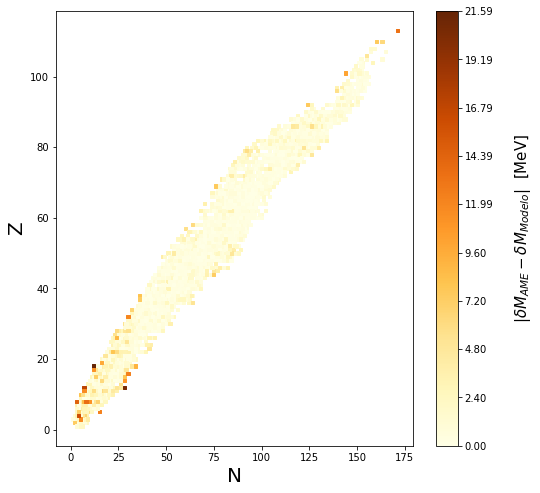

In [34]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = PRED, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(PRED),max(PRED),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = abs(PRED-FULLDATAY), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(PRED-FULLDATAY)),max(abs(PRED-FULLDATAY)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFDIFF.png',dpi = 500)
plt.show()

In [35]:
print("RMS del modelo: ", RMS(PRED,FULLDATAY), 'MeV')

RMS del modelo:  1.9547941170066458 MeV


# M11

In [14]:
# GridSearch
model11 = RandomForestRegressor()
hyperparam = {'n_estimators':[3000,2000]}
fitter = GridSearchCV(model11, hyperparam)

In [15]:
Y11= Y11.reshape(np.shape(X11)[0],)
fitter.fit(X11,Y11)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [3000, 2000]})

In [16]:
fitter.best_params_

{'n_estimators': 3000}

In [17]:
# Se entrena el modelo
model11 = RandomForestRegressor(n_estimators= 3000)
Y11 = Y11.reshape(np.shape(X11)[0],)
model11.fit(X11,Y11)

RandomForestRegressor(n_estimators=3000)

In [18]:
print("Coeficiente de determinación del modelo para los datos de training: ",model11.score(X11, Y11))
print("Coeficiente de determinación del modelo para los datos de test: ",model11.score(XT, YT))

Coeficiente de determinación del modelo para los datos de training:  0.9992226562653524
Coeficiente de determinación del modelo para los datos de test:  0.5510195606880115


In [19]:
PRED11 = model11.predict(X11)
PREDFRDM = model11.predict(XT)

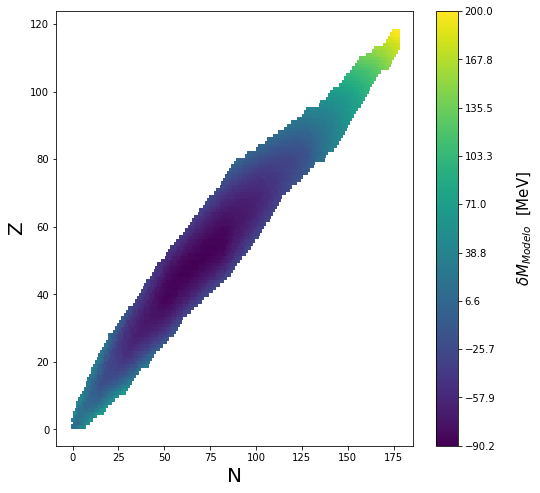

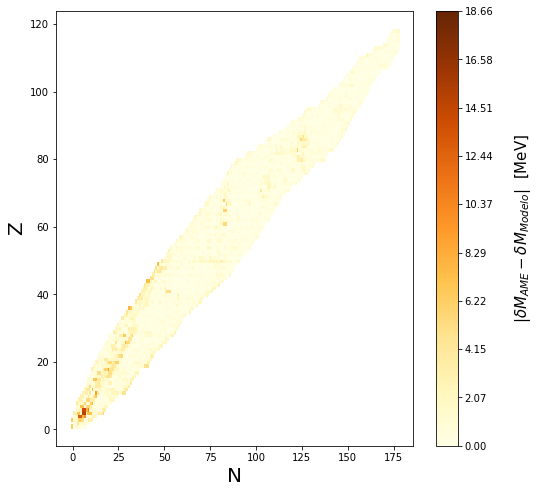

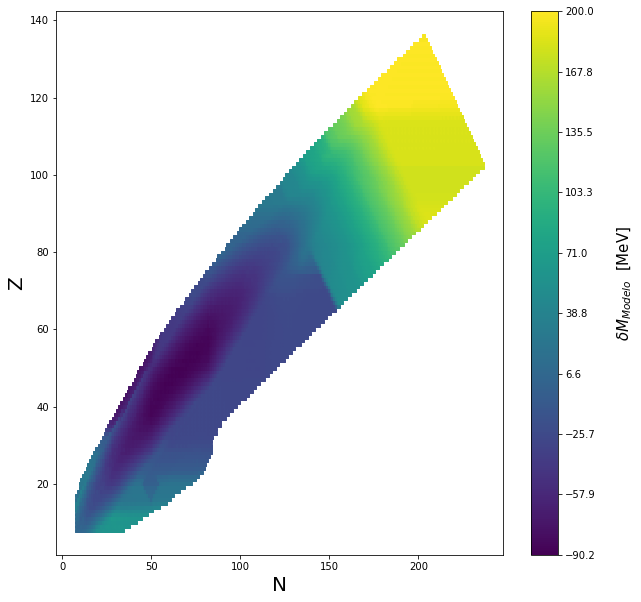

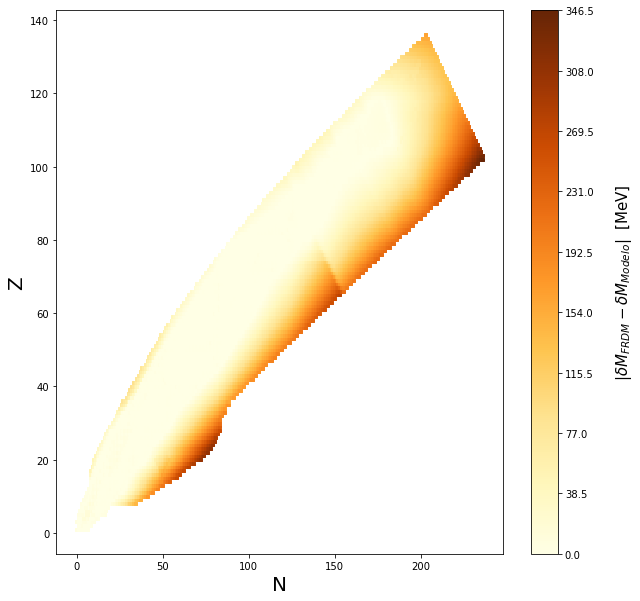

In [20]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2],X11[:,1], c = PRED11, s = 10, marker=',')
#plt.scatter(XT[:,2],XT[:,1], c = PREDFRDM, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(PRED11),max(PRED11),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2], X11[:,1], c = abs(PRED11-Y11), s = 10, marker=',', cmap = 'YlOrBr')
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT))), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(PRED11-Y11)),max(abs(PRED11-Y11)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFF.png',dpi = 500)
plt.show()


# Predicciones del modelo
fig = plt.figure(figsize = (10,10))
plt.scatter(XT[:,2],XT[:,1], c = PREDFRDM, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(PREDFRDM),max(PREDFRDM),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFPREDv3.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (10,10))
plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT))), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT)))),max(abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT)))),10)).set_label(label='|$\delta M_{FRDM}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFFv3.png',dpi = 500)
plt.show()

In [21]:
# Se quitan los valores de FRDM en los datos de training 
Z11_TRUNC =  np.array(XT[:,1])
N11_TRUNC = np.array(XT[:,2])
PREDFRDM_TRUNC = np.array(PREDFRDM)
YT_TRUNC = YT 
        
for i in range(0,len(X11[:,2])):
    for j in range(0,len(N11_TRUNC)):
        
        if (X11[i,2] == N11_TRUNC[j]):
            if (X11[i,1] == Z11_TRUNC[j]):
                
                Z11_TRUNC = np.delete(Z11_TRUNC, j)
                N11_TRUNC = np.delete(N11_TRUNC, j)
                PREDFRDM_TRUNC = np.delete(PREDFRDM_TRUNC, j)
                YT_TRUNC = np.delete(YT_TRUNC, j)
                break

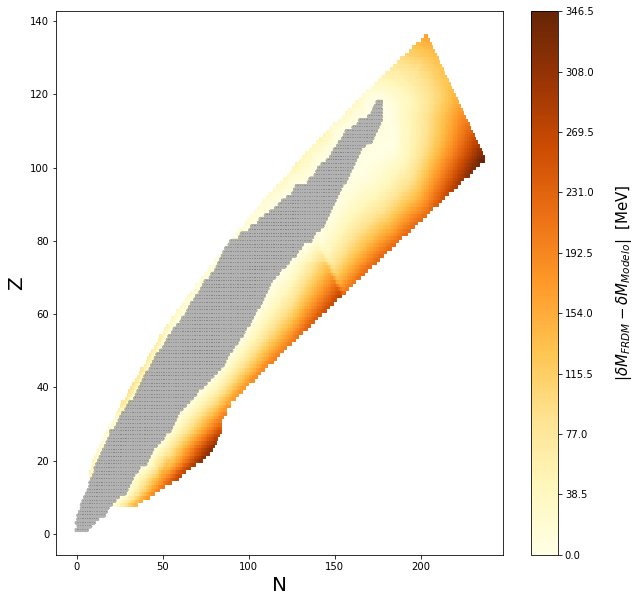

In [22]:
# Diferencias
diff = abs(PREDFRDM_TRUNC - YT_TRUNC)

fig = plt.figure(figsize = (10,10))
plt.scatter(N11_TRUNC, Z11_TRUNC, c = diff, s = 10, marker=',', cmap = 'YlOrBr')
plt.plot(X11[:,2], X11[:,1], color ='grey', marker=',', linewidth=4, alpha = 0.6)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(diff),max(diff),10)).set_label(label='|$\delta M_{FRDM}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFF_TRUNCv3.png',dpi = 500)
plt.show()

In [25]:
print("RMS del modelo: ", RMS(PRED11 ,Y11), 'MeV')

RMS del modelo:  1.510441085883801 MeV


# Modelo de Mixture Density Network (MDN)

### M12

In [1]:
import tensorflow as tf
from tensorflow import keras
import mdn

2022-11-23 10:52:02.717826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 10:52:02.912945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 10:52:02.912969: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-23 10:52:04.412084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

ModuleNotFoundError: No module named 'tensorflow_probability'

In [6]:
# Modelo de mixture density network
N_HIDDEN = 10  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model12 = keras.Sequential()
model12.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 12), activation='tanh'))
model12.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model12.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam( learning_rate=0.001))
model12.summary()

AttributeError: module 'mdn' has no attribute 'MDN'

In [13]:
history = model12.fit(x=X12TR, y=Y12TR, batch_size=128, epochs=100, validation_data=(X12TE, Y12TE))

Epoch 1/100
14/14 [==============================] - 3s 36ms/step - loss: 406.8195 - val_loss: 343.0512
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 341.4867 - val_loss: 292.1323
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 291.7744 - val_loss: 255.0042
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 262.3225 - val_loss: 231.4345
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 239.6054 - val_loss: 211.8866
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 213.1491 - val_loss: 173.3547
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 180.9571 - val_loss: 163.1346
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 171.5958 - val_loss: 155.0373
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 163.1670 - val_loss: 147.6734
Epoch 10/100
14/14 [==============================] - 0s 6ms/step - loss

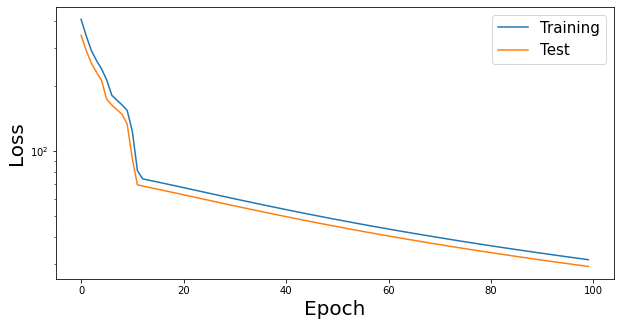

In [14]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Test')

plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend(fontsize=15)
plt.yscale('log')

plt.savefig('LossvsEpoch.png',dpi = 500)
plt.show()

In [15]:
FULLDATA12 = np.concatenate((X12TR,X12TE))
FULLDATAY = np.concatenate((Y12TR,Y12TE))

In [17]:
# Predicción del modelo
y_test = model12.predict(FULLDATA12)
y_test

69/69 [==============================] - 0s 2ms/step


array([[-5.5413456,  7.3088393, -1.07557  ],
       [-5.9893646,  7.3322487, -1.0221024],
       [-5.9893646,  7.3322487, -1.0221024],
       ...,
       [-5.9893646,  7.3322487, -1.0221024],
       [-5.9893646,  7.3322487, -1.0221024],
       [-5.9893646,  7.3322487, -1.0221024]], dtype=float32)

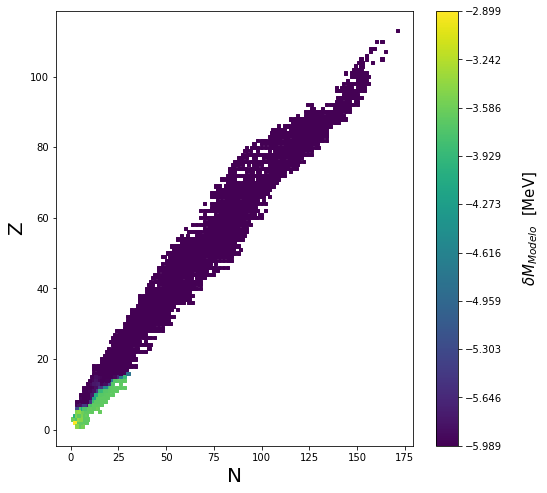

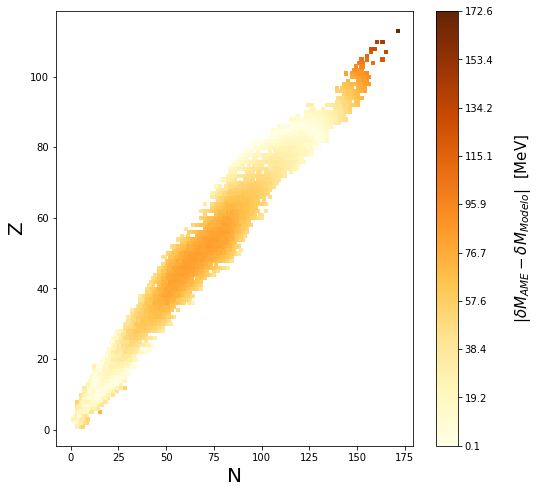

In [19]:
# Valores medios del modelo

# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = y_test[:,0].reshape(2191,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test[:,0].reshape(2191,-1)),max(y_test[:,0].reshape(2191,-1)),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNPREDmean.png',dpi = 500)
plt.show()

# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = abs(y_test[:,0].reshape(2191,-1)-FULLDATAY), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(y_test[:,0].reshape(2191,-1)-FULLDATAY)),max(abs(y_test[:,0].reshape(2191,-1)-FULLDATAY)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNDIFFmean.png',dpi = 500)
plt.show()

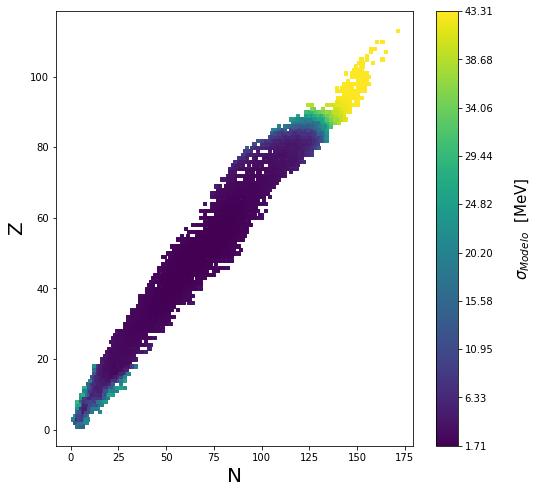

In [38]:
# Desviaciones estándar del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = y_test[:,1].reshape(2191,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test[:,1].reshape(2191,-1)),max(y_test[:,1].reshape(2191,-1)),10)).set_label(label='$\sigma_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12MDNPREDsigma.png',dpi = 500)
plt.show()

In [39]:
print("RMS del modelo: ", RMS(FULLDATAY , y_test[:,0].reshape(2191,-1))[0], 'MeV')

RMS del modelo:  12.41282769278154 MeV


### M11

In [40]:
# Modelo de mixture density network
N_HIDDEN = 6  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model11 = keras.Sequential()
model11.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 11), activation='tanh'))
model11.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model11.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam( learning_rate=0.001))
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 72        
                                                                 
 mdn_3 (MDN)                 (None, 3)                 21        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model11.fit(x=X11, y=Y11, batch_size=128, epochs=10000, validation_data=(X11, Y11))

Epoch 1/10000
46/46 [==============================] - 3s 11ms/step - loss: 12665.6963 - val_loss: 9081.0605
Epoch 2/10000
46/46 [==============================] - 0s 5ms/step - loss: 7252.7656 - val_loss: 5739.9106
Epoch 3/10000
46/46 [==============================] - 0s 5ms/step - loss: 4837.5059 - val_loss: 4025.8943
Epoch 4/10000
46/46 [==============================] - 0s 5ms/step - loss: 3499.1387 - val_loss: 3014.6794
Epoch 5/10000
46/46 [==============================] - 0s 5ms/step - loss: 2669.1562 - val_loss: 2341.2231
Epoch 6/10000
46/46 [==============================] - 0s 5ms/step - loss: 1210.8573 - val_loss: 444.9270
Epoch 7/10000
46/46 [==============================] - 0s 5ms/step - loss: 442.1037 - val_loss: 439.2926
Epoch 8/10000
46/46 [==============================] - 0s 5ms/step - loss: 436.6826 - val_loss: 433.8494
Epoch 9/10000
46/46 [==============================] - 0s 5ms/step - loss: 431.1319 - val_loss: 428.1924
Epoch 10/10000
46/46 [====================

Epoch 156/10000
46/46 [==============================] - 0s 5ms/step - loss: 56.0841 - val_loss: 55.7467
Epoch 157/10000
46/46 [==============================] - 0s 5ms/step - loss: 55.4360 - val_loss: 55.1069
Epoch 158/10000
46/46 [==============================] - 0s 5ms/step - loss: 54.7968 - val_loss: 54.4697
Epoch 159/10000
46/46 [==============================] - 0s 5ms/step - loss: 54.1660 - val_loss: 53.8412
Epoch 160/10000
46/46 [==============================] - 0s 5ms/step - loss: 53.5437 - val_loss: 53.2277
Epoch 161/10000
46/46 [==============================] - 0s 5ms/step - loss: 52.9288 - val_loss: 52.6189
Epoch 162/10000
46/46 [==============================] - 0s 5ms/step - loss: 52.3245 - val_loss: 52.0112
Epoch 163/10000
46/46 [==============================] - 0s 5ms/step - loss: 51.7245 - val_loss: 51.4180
Epoch 164/10000
46/46 [==============================] - 0s 5ms/step - loss: 51.1347 - val_loss: 50.8368
Epoch 165/10000
46/46 [==============================] 

46/46 [==============================] - 0s 5ms/step - loss: 24.2838 - val_loss: 24.1611
Epoch 235/10000
46/46 [==============================] - 0s 5ms/step - loss: 24.0483 - val_loss: 23.9242
Epoch 236/10000
46/46 [==============================] - 0s 5ms/step - loss: 23.8148 - val_loss: 23.6950
Epoch 237/10000
46/46 [==============================] - 0s 5ms/step - loss: 23.5849 - val_loss: 23.4687
Epoch 238/10000
46/46 [==============================] - 0s 5ms/step - loss: 23.3578 - val_loss: 23.2448
Epoch 239/10000
46/46 [==============================] - 0s 5ms/step - loss: 23.1340 - val_loss: 23.0176
Epoch 240/10000
46/46 [==============================] - 0s 5ms/step - loss: 22.9122 - val_loss: 22.7970
Epoch 241/10000
46/46 [==============================] - 0s 5ms/step - loss: 22.6931 - val_loss: 22.5825
Epoch 242/10000
46/46 [==============================] - 0s 5ms/step - loss: 22.4772 - val_loss: 22.3674
Epoch 243/10000
46/46 [==============================] - 0s 5ms/step - 

46/46 [==============================] - 0s 5ms/step - loss: 7.7312 - val_loss: 7.7127
Epoch 392/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.6967 - val_loss: 7.6788
Epoch 393/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.6625 - val_loss: 7.6455
Epoch 394/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.6289 - val_loss: 7.6115
Epoch 395/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.5956 - val_loss: 7.5783
Epoch 396/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.5625 - val_loss: 7.5457
Epoch 397/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.5300 - val_loss: 7.5134
Epoch 398/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.4979 - val_loss: 7.4815
Epoch 399/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.4666 - val_loss: 7.4500
Epoch 400/10000
46/46 [==============================] - 0s 5ms/step - loss: 7.4355 - val

46/46 [==============================] - 0s 5ms/step - loss: 5.4477 - val_loss: 5.4453
Epoch 550/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4437 - val_loss: 5.4421
Epoch 551/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4403 - val_loss: 5.4381
Epoch 552/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4366 - val_loss: 5.4346
Epoch 553/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4333 - val_loss: 5.4315
Epoch 554/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4300 - val_loss: 5.4279
Epoch 555/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4269 - val_loss: 5.4258
Epoch 556/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4235 - val_loss: 5.4218
Epoch 557/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4206 - val_loss: 5.4186
Epoch 558/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.4175 - val

46/46 [==============================] - 0s 5ms/step - loss: 5.0353 - val_loss: 5.0326
Epoch 708/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0323 - val_loss: 5.0310
Epoch 709/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0296 - val_loss: 5.0281
Epoch 710/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0276 - val_loss: 5.0273
Epoch 711/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0256 - val_loss: 5.0236
Epoch 712/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0232 - val_loss: 5.0210
Epoch 713/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0233 - val_loss: 5.0199
Epoch 714/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0200 - val_loss: 5.0172
Epoch 715/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0178 - val_loss: 5.0159
Epoch 716/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0168 - val

46/46 [==============================] - 0s 5ms/step - loss: 4.8739 - val_loss: 4.8717
Epoch 866/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8730 - val_loss: 4.8703
Epoch 867/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8701 - val_loss: 4.8673
Epoch 868/10000
46/46 [==============================] - 0s 4ms/step - loss: 4.8667 - val_loss: 4.8649
Epoch 869/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8651 - val_loss: 4.8645
Epoch 870/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8662 - val_loss: 4.8636
Epoch 871/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8636 - val_loss: 4.8608
Epoch 872/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8641 - val_loss: 4.8631
Epoch 873/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8606 - val_loss: 4.8561
Epoch 874/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.8557 - val

46/46 [==============================] - 0s 5ms/step - loss: 5.3453 - val_loss: 5.3452
Epoch 1024/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3452 - val_loss: 5.3451
Epoch 1025/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3450 - val_loss: 5.3449
Epoch 1026/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3448 - val_loss: 5.3447
Epoch 1027/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3447 - val_loss: 5.3446
Epoch 1028/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3445 - val_loss: 5.3444
Epoch 1029/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3443 - val_loss: 5.3442
Epoch 1030/10000
46/46 [==============================] - 0s 6ms/step - loss: 5.3441 - val_loss: 5.3440
Epoch 1031/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3439 - val_loss: 5.3438
Epoch 1032/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3

Epoch 1102/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3734 - val_loss: 5.3730
Epoch 1103/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3726 - val_loss: 5.3721
Epoch 1104/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3716 - val_loss: 5.3710
Epoch 1105/10000
46/46 [==============================] - 0s 6ms/step - loss: 5.3705 - val_loss: 5.3698
Epoch 1106/10000
46/46 [==============================] - 0s 6ms/step - loss: 5.3692 - val_loss: 5.3683
Epoch 1107/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3675 - val_loss: 5.3665
Epoch 1108/10000
46/46 [==============================] - 0s 6ms/step - loss: 5.3654 - val_loss: 5.3641
Epoch 1109/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3627 - val_loss: 5.3609
Epoch 1110/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.3592 - val_loss: 5.3572
Epoch 1111/10000
46/46 [==============================] - 0s 5ms

Epoch 1181/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2138 - val_loss: 5.2138
Epoch 1182/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2137 - val_loss: 5.2135
Epoch 1183/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2136 - val_loss: 5.2136
Epoch 1184/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2135 - val_loss: 5.2135
Epoch 1185/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2136 - val_loss: 5.2133
Epoch 1186/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2134 - val_loss: 5.2132
Epoch 1187/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2133 - val_loss: 5.2133
Epoch 1188/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2134 - val_loss: 5.2135
Epoch 1189/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.2132 - val_loss: 5.2130
Epoch 1190/10000
46/46 [==============================] - 0s 5ms

Epoch 1260/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1736 - val_loss: 5.1736
Epoch 1261/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1734 - val_loss: 5.1739
Epoch 1262/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1730 - val_loss: 5.1737
Epoch 1263/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1732 - val_loss: 5.1730
Epoch 1264/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1726 - val_loss: 5.1723
Epoch 1265/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1724 - val_loss: 5.1719
Epoch 1266/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1721 - val_loss: 5.1716
Epoch 1267/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1715 - val_loss: 5.1715
Epoch 1268/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1729 - val_loss: 5.1735
Epoch 1269/10000
46/46 [==============================] - 0s 5ms

Epoch 1339/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1213 - val_loss: 5.1201
Epoch 1340/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1200 - val_loss: 5.1181
Epoch 1341/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1182 - val_loss: 5.1178
Epoch 1342/10000
46/46 [==============================] - 0s 4ms/step - loss: 5.1186 - val_loss: 5.1187
Epoch 1343/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1150 - val_loss: 5.1151
Epoch 1344/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.1175 - val_loss: 5.1125
Epoch 1345/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0926 - val_loss: 5.0736
Epoch 1346/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0678 - val_loss: 5.0623
Epoch 1347/10000
46/46 [==============================] - 0s 5ms/step - loss: 5.0604 - val_loss: 5.0571
Epoch 1348/10000
46/46 [==============================] - 0s 5ms

Epoch 1418/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7608 - val_loss: 4.7577
Epoch 1419/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7555 - val_loss: 4.7556
Epoch 1420/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7519 - val_loss: 4.7471
Epoch 1421/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7454 - val_loss: 4.7443
Epoch 1422/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7399 - val_loss: 4.7368
Epoch 1423/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7346 - val_loss: 4.7310
Epoch 1424/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7286 - val_loss: 4.7246
Epoch 1425/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7232 - val_loss: 4.7203
Epoch 1426/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.7192 - val_loss: 4.7156
Epoch 1427/10000
46/46 [==============================] - 0s 5ms

Epoch 1497/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3376 - val_loss: 4.3380
Epoch 1498/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3234 - val_loss: 4.3116
Epoch 1499/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3174 - val_loss: 4.3176
Epoch 1500/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3153 - val_loss: 4.3028
Epoch 1501/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3022 - val_loss: 4.3002
Epoch 1502/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3001 - val_loss: 4.2994
Epoch 1503/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3042 - val_loss: 4.3180
Epoch 1504/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.3269 - val_loss: 4.3132
Epoch 1505/10000
46/46 [==============================] - 0s 5ms/step - loss: 4.2930 - val_loss: 4.2813
Epoch 1506/10000
46/46 [==============================] - 0s 5ms

Epoch 1576/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9967 - val_loss: 4.0017
Epoch 1577/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9849 - val_loss: 4.0217
Epoch 1578/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9855 - val_loss: 3.9712
Epoch 1579/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9779 - val_loss: 4.0147
Epoch 1580/10000
46/46 [==============================] - 0s 6ms/step - loss: 3.9733 - val_loss: 4.0485
Epoch 1581/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.9970 - val_loss: 3.9727
Epoch 1582/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.9708 - val_loss: 3.9428
Epoch 1583/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9618 - val_loss: 3.9918
Epoch 1584/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.9558 - val_loss: 3.9483
Epoch 1585/10000
46/46 [==============================] - 0s 5ms

Epoch 1655/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4730 - val_loss: 3.4894
Epoch 1656/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4631 - val_loss: 3.4928
Epoch 1657/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4615 - val_loss: 3.5073
Epoch 1658/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4712 - val_loss: 3.4440
Epoch 1659/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4712 - val_loss: 3.5721
Epoch 1660/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4700 - val_loss: 3.4401
Epoch 1661/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4947 - val_loss: 3.4709
Epoch 1662/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4963 - val_loss: 3.4772
Epoch 1663/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4647 - val_loss: 3.4613
Epoch 1664/10000
46/46 [==============================] - 0s 5ms

Epoch 1734/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.4092 - val_loss: 3.4264
Epoch 1735/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3599 - val_loss: 3.3214
Epoch 1736/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3904 - val_loss: 3.3360
Epoch 1737/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3471 - val_loss: 3.3331
Epoch 1738/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3860 - val_loss: 3.4685
Epoch 1739/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.3603 - val_loss: 3.3299
Epoch 1740/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3287 - val_loss: 3.3824
Epoch 1741/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3601 - val_loss: 3.4604
Epoch 1742/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3751 - val_loss: 3.3108
Epoch 1743/10000
46/46 [==============================] - 0s 5ms

Epoch 1813/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.2811 - val_loss: 3.2688
Epoch 1814/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2829 - val_loss: 3.5058
Epoch 1815/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3971 - val_loss: 3.4041
Epoch 1816/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2954 - val_loss: 3.2323
Epoch 1817/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2450 - val_loss: 3.3605
Epoch 1818/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3002 - val_loss: 3.2283
Epoch 1819/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2775 - val_loss: 3.7688
Epoch 1820/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3136 - val_loss: 3.3140
Epoch 1821/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2739 - val_loss: 3.2454
Epoch 1822/10000
46/46 [==============================] - 0s 4ms

Epoch 1892/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2952 - val_loss: 3.3131
Epoch 1893/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2260 - val_loss: 3.1956
Epoch 1894/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2612 - val_loss: 3.2461
Epoch 1895/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.2102 - val_loss: 3.1767
Epoch 1896/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.2519 - val_loss: 3.2221
Epoch 1897/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2222 - val_loss: 3.3017
Epoch 1898/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2034 - val_loss: 3.1831
Epoch 1899/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1905 - val_loss: 3.2042
Epoch 1900/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2097 - val_loss: 3.1897
Epoch 1901/10000
46/46 [==============================] - 0s 5ms

Epoch 1971/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1892 - val_loss: 3.2099
Epoch 1972/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1672 - val_loss: 3.1424
Epoch 1973/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2211 - val_loss: 3.1586
Epoch 1974/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1567 - val_loss: 3.1753
Epoch 1975/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1851 - val_loss: 3.1289
Epoch 1976/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1984 - val_loss: 3.1293
Epoch 1977/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1653 - val_loss: 3.1669
Epoch 1978/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1889 - val_loss: 3.1305
Epoch 1979/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1915 - val_loss: 3.3111
Epoch 1980/10000
46/46 [==============================] - 0s 5ms

Epoch 2050/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1242 - val_loss: 3.2006
Epoch 2051/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1752 - val_loss: 3.2015
Epoch 2052/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1435 - val_loss: 3.2448
Epoch 2053/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3509 - val_loss: 3.2536
Epoch 2054/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1409 - val_loss: 3.2428
Epoch 2055/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1189 - val_loss: 3.1053
Epoch 2056/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1156 - val_loss: 3.0952
Epoch 2057/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1500 - val_loss: 3.1354
Epoch 2058/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3278 - val_loss: 3.2092
Epoch 2059/10000
46/46 [==============================] - 0s 5ms

Epoch 2129/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1110 - val_loss: 3.1407
Epoch 2130/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1072 - val_loss: 3.1774
Epoch 2131/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1200 - val_loss: 3.1283
Epoch 2132/10000
46/46 [==============================] - 0s 4ms/step - loss: 3.1199 - val_loss: 3.0990
Epoch 2133/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.2035 - val_loss: 3.0756
Epoch 2134/10000
46/46 [==============================] - 0s 6ms/step - loss: 3.1737 - val_loss: 3.0808
Epoch 2135/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1618 - val_loss: 3.1219
Epoch 2136/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1023 - val_loss: 3.1122
Epoch 2137/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0968 - val_loss: 3.1007
Epoch 2138/10000
46/46 [==============================] - 0s 5ms

Epoch 2208/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1490 - val_loss: 3.0667
Epoch 2209/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0964 - val_loss: 3.0446
Epoch 2210/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0875 - val_loss: 3.0980
Epoch 2211/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1085 - val_loss: 3.0511
Epoch 2212/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1090 - val_loss: 3.0452
Epoch 2213/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0557 - val_loss: 3.0794
Epoch 2214/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0930 - val_loss: 3.0307
Epoch 2215/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1767 - val_loss: 3.0429
Epoch 2216/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1318 - val_loss: 3.0865
Epoch 2217/10000
46/46 [==============================] - 0s 5ms

Epoch 2287/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9601 - val_loss: 2.9509
Epoch 2288/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9461 - val_loss: 2.9631
Epoch 2289/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9581 - val_loss: 2.9846
Epoch 2290/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.3067 - val_loss: 2.9906
Epoch 2291/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9426 - val_loss: 3.0077
Epoch 2292/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9747 - val_loss: 2.9315
Epoch 2293/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0062 - val_loss: 3.1095
Epoch 2294/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0243 - val_loss: 2.9154
Epoch 2295/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9583 - val_loss: 2.9078
Epoch 2296/10000
46/46 [==============================] - 0s 5ms

Epoch 2366/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0855 - val_loss: 3.0260
Epoch 2367/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9678 - val_loss: 2.8721
Epoch 2368/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8759 - val_loss: 2.8429
Epoch 2369/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8778 - val_loss: 2.9278
Epoch 2370/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9012 - val_loss: 3.0762
Epoch 2371/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0726 - val_loss: 3.1565
Epoch 2372/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9481 - val_loss: 2.8624
Epoch 2373/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8613 - val_loss: 2.8547
Epoch 2374/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8609 - val_loss: 2.8932
Epoch 2375/10000
46/46 [==============================] - 0s 5ms

Epoch 2445/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8521 - val_loss: 2.8530
Epoch 2446/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8655 - val_loss: 2.9758
Epoch 2447/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9868 - val_loss: 2.9393
Epoch 2448/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8895 - val_loss: 2.8330
Epoch 2449/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8993 - val_loss: 2.8313
Epoch 2450/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9339 - val_loss: 2.8716
Epoch 2451/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8539 - val_loss: 2.8027
Epoch 2452/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8695 - val_loss: 2.8304
Epoch 2453/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8544 - val_loss: 2.9595
Epoch 2454/10000
46/46 [==============================] - 0s 5ms

Epoch 2524/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0909 - val_loss: 3.1352
Epoch 2525/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8614 - val_loss: 2.7951
Epoch 2526/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8757 - val_loss: 3.0258
Epoch 2527/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8467 - val_loss: 2.7847
Epoch 2528/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8562 - val_loss: 2.7915
Epoch 2529/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8184 - val_loss: 2.7579
Epoch 2530/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8191 - val_loss: 2.9475
Epoch 2531/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0426 - val_loss: 2.9897
Epoch 2532/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8721 - val_loss: 2.9064
Epoch 2533/10000
46/46 [==============================] - 0s 5ms

Epoch 2603/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9791 - val_loss: 2.9904
Epoch 2604/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8652 - val_loss: 2.9076
Epoch 2605/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8506 - val_loss: 2.8181
Epoch 2606/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8733 - val_loss: 2.8102
Epoch 2607/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8040 - val_loss: 2.9302
Epoch 2608/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8818 - val_loss: 2.7669
Epoch 2609/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8547 - val_loss: 2.8326
Epoch 2610/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9217 - val_loss: 2.8919
Epoch 2611/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8741 - val_loss: 3.6830
Epoch 2612/10000
46/46 [==============================] - 0s 5ms

Epoch 2682/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9490 - val_loss: 2.7910
Epoch 2683/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8696 - val_loss: 2.9203
Epoch 2684/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7876 - val_loss: 2.7641
Epoch 2685/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8044 - val_loss: 2.7558
Epoch 2686/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7943 - val_loss: 2.7460
Epoch 2687/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7960 - val_loss: 2.7263
Epoch 2688/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0813 - val_loss: 2.9712
Epoch 2689/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9008 - val_loss: 3.3019
Epoch 2690/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8741 - val_loss: 2.7906
Epoch 2691/10000
46/46 [==============================] - 0s 4ms

Epoch 2761/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1241 - val_loss: 3.0077
Epoch 2762/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8159 - val_loss: 2.7434
Epoch 2763/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7602 - val_loss: 2.7303
Epoch 2764/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7525 - val_loss: 2.7462
Epoch 2765/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7450 - val_loss: 2.7825
Epoch 2766/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9057 - val_loss: 2.7300
Epoch 2767/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7949 - val_loss: 2.7253
Epoch 2768/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9064 - val_loss: 2.9048
Epoch 2769/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9399 - val_loss: 3.3270
Epoch 2770/10000
46/46 [==============================] - 0s 5ms

Epoch 2840/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8670 - val_loss: 2.7834
Epoch 2841/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8339 - val_loss: 3.2847
Epoch 2842/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8914 - val_loss: 2.7276
Epoch 2843/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7640 - val_loss: 2.7200
Epoch 2844/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8291 - val_loss: 2.7163
Epoch 2845/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7399 - val_loss: 2.7357
Epoch 2846/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8020 - val_loss: 2.7002
Epoch 2847/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7846 - val_loss: 2.7344
Epoch 2848/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7866 - val_loss: 2.8030
Epoch 2849/10000
46/46 [==============================] - 0s 5ms

Epoch 2919/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7708 - val_loss: 2.7067
Epoch 2920/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8516 - val_loss: 2.7460
Epoch 2921/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7920 - val_loss: 2.8487
Epoch 2922/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7396 - val_loss: 2.7449
Epoch 2923/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9029 - val_loss: 2.8254
Epoch 2924/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8133 - val_loss: 2.8787
Epoch 2925/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7886 - val_loss: 2.7810
Epoch 2926/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7249 - val_loss: 2.8716
Epoch 2927/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7648 - val_loss: 2.7839
Epoch 2928/10000
46/46 [==============================] - 0s 5ms

Epoch 2998/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7976 - val_loss: 2.8220
Epoch 2999/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8840 - val_loss: 2.8077
Epoch 3000/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8586 - val_loss: 2.7773
Epoch 3001/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8019 - val_loss: 2.9604
Epoch 3002/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8213 - val_loss: 2.9409
Epoch 3003/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9807 - val_loss: 3.5476
Epoch 3004/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8450 - val_loss: 2.7401
Epoch 3005/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7909 - val_loss: 2.7191
Epoch 3006/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7534 - val_loss: 2.9024
Epoch 3007/10000
46/46 [==============================] - 0s 5ms

Epoch 3077/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8491 - val_loss: 2.7310
Epoch 3078/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7948 - val_loss: 2.8727
Epoch 3079/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8646 - val_loss: 3.0234
Epoch 3080/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8205 - val_loss: 2.7121
Epoch 3081/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8228 - val_loss: 2.8576
Epoch 3082/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9007 - val_loss: 2.7510
Epoch 3083/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7561 - val_loss: 2.7098
Epoch 3084/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7417 - val_loss: 2.8387
Epoch 3085/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7534 - val_loss: 2.7535
Epoch 3086/10000
46/46 [==============================] - 0s 4ms

Epoch 3156/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7929 - val_loss: 2.6980
Epoch 3157/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8755 - val_loss: 2.8723
Epoch 3158/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7360 - val_loss: 2.8430
Epoch 3159/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7412 - val_loss: 2.6883
Epoch 3160/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7495 - val_loss: 2.6598
Epoch 3161/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9462 - val_loss: 3.1232
Epoch 3162/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7480 - val_loss: 2.6772
Epoch 3163/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7951 - val_loss: 2.9984
Epoch 3164/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7958 - val_loss: 2.7200
Epoch 3165/10000
46/46 [==============================] - 0s 5ms

Epoch 3235/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7928 - val_loss: 3.2282
Epoch 3236/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8923 - val_loss: 2.9128
Epoch 3237/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8347 - val_loss: 2.8547
Epoch 3238/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8484 - val_loss: 2.8164
Epoch 3239/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7295 - val_loss: 2.7099
Epoch 3240/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7584 - val_loss: 2.7042
Epoch 3241/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8051 - val_loss: 2.6917
Epoch 3242/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7292 - val_loss: 2.7614
Epoch 3243/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8336 - val_loss: 2.7843
Epoch 3244/10000
46/46 [==============================] - 0s 6ms

Epoch 3314/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8298 - val_loss: 2.8490
Epoch 3315/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8370 - val_loss: 2.7264
Epoch 3316/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7374 - val_loss: 2.6762
Epoch 3317/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7712 - val_loss: 2.7572
Epoch 3318/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7171 - val_loss: 2.7645
Epoch 3319/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8045 - val_loss: 2.7276
Epoch 3320/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8357 - val_loss: 2.7495
Epoch 3321/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7655 - val_loss: 2.6568
Epoch 3322/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7198 - val_loss: 3.2112
Epoch 3323/10000
46/46 [==============================] - 0s 5ms

Epoch 3393/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7454 - val_loss: 2.6950
Epoch 3394/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8144 - val_loss: 2.7282
Epoch 3395/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0199 - val_loss: 3.0296
Epoch 3396/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8051 - val_loss: 2.6845
Epoch 3397/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7918 - val_loss: 2.7223
Epoch 3398/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7138 - val_loss: 2.6645
Epoch 3399/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7879 - val_loss: 2.7130
Epoch 3400/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8202 - val_loss: 2.6796
Epoch 3401/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7117 - val_loss: 2.7710
Epoch 3402/10000
46/46 [==============================] - 0s 5ms

Epoch 3472/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8104 - val_loss: 2.6873
Epoch 3473/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7118 - val_loss: 2.6926
Epoch 3474/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7405 - val_loss: 2.6655
Epoch 3475/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7553 - val_loss: 2.6525
Epoch 3476/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0146 - val_loss: 2.6938
Epoch 3477/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7100 - val_loss: 2.6999
Epoch 3478/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7914 - val_loss: 2.8656
Epoch 3479/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7602 - val_loss: 2.6632
Epoch 3480/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8034 - val_loss: 2.7374
Epoch 3481/10000
46/46 [==============================] - 0s 5ms

Epoch 3551/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7105 - val_loss: 2.6411
Epoch 3552/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7093 - val_loss: 2.7679
Epoch 3553/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8616 - val_loss: 2.7643
Epoch 3554/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7843 - val_loss: 2.6538
Epoch 3555/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7085 - val_loss: 3.2309
Epoch 3556/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0677 - val_loss: 2.6935
Epoch 3557/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8138 - val_loss: 2.9067
Epoch 3558/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7304 - val_loss: 2.6966
Epoch 3559/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7723 - val_loss: 2.7339
Epoch 3560/10000
46/46 [==============================] - 0s 5ms

Epoch 3630/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7074 - val_loss: 3.0090
Epoch 3631/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7055 - val_loss: 2.6301
Epoch 3632/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8655 - val_loss: 2.7142
Epoch 3633/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6679 - val_loss: 2.6392
Epoch 3634/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8180 - val_loss: 2.9118
Epoch 3635/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7497 - val_loss: 2.6794
Epoch 3636/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6789 - val_loss: 2.7020
Epoch 3637/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6989 - val_loss: 2.7569
Epoch 3638/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7002 - val_loss: 2.6231
Epoch 3639/10000
46/46 [==============================] - 0s 5ms

Epoch 3709/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7105 - val_loss: 2.9825
Epoch 3710/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9273 - val_loss: 2.6931
Epoch 3711/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7595 - val_loss: 2.9542
Epoch 3712/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7277 - val_loss: 3.1890
Epoch 3713/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7192 - val_loss: 2.6414
Epoch 3714/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7331 - val_loss: 2.6458
Epoch 3715/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7335 - val_loss: 2.6470
Epoch 3716/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6746 - val_loss: 2.8587
Epoch 3717/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7682 - val_loss: 2.6517
Epoch 3718/10000
46/46 [==============================] - 0s 5ms

Epoch 3788/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7130 - val_loss: 2.7205
Epoch 3789/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7380 - val_loss: 3.6547
Epoch 3790/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9860 - val_loss: 2.7436
Epoch 3791/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6951 - val_loss: 2.6627
Epoch 3792/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6509 - val_loss: 2.6368
Epoch 3793/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7723 - val_loss: 2.9592
Epoch 3794/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1361 - val_loss: 2.7251
Epoch 3795/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7097 - val_loss: 2.6563
Epoch 3796/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7315 - val_loss: 2.6879
Epoch 3797/10000
46/46 [==============================] - 0s 5ms

Epoch 3867/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8314 - val_loss: 2.8281
Epoch 3868/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7619 - val_loss: 2.8135
Epoch 3869/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7960 - val_loss: 2.7901
Epoch 3870/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1234 - val_loss: 2.9984
Epoch 3871/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7948 - val_loss: 2.7136
Epoch 3872/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7175 - val_loss: 2.7332
Epoch 3873/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7595 - val_loss: 3.0835
Epoch 3874/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8956 - val_loss: 2.7008
Epoch 3875/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7554 - val_loss: 2.8112
Epoch 3876/10000
46/46 [==============================] - 0s 5ms

Epoch 3946/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6988 - val_loss: 2.7159
Epoch 3947/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.1999 - val_loss: 3.1775
Epoch 3948/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7482 - val_loss: 2.8118
Epoch 3949/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6921 - val_loss: 2.6538
Epoch 3950/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7297 - val_loss: 2.6662
Epoch 3951/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7406 - val_loss: 3.1275
Epoch 3952/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7238 - val_loss: 2.8355
Epoch 3953/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9253 - val_loss: 2.7630
Epoch 3954/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7296 - val_loss: 2.6562
Epoch 3955/10000
46/46 [==============================] - 0s 5ms

Epoch 4025/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7167 - val_loss: 2.7070
Epoch 4026/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6929 - val_loss: 2.7635
Epoch 4027/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7775 - val_loss: 2.7643
Epoch 4028/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7171 - val_loss: 2.6107
Epoch 4029/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7710 - val_loss: 2.9036
Epoch 4030/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6993 - val_loss: 2.6173
Epoch 4031/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7048 - val_loss: 2.6784
Epoch 4032/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7471 - val_loss: 2.8909
Epoch 4033/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7266 - val_loss: 2.6686
Epoch 4034/10000
46/46 [==============================] - 0s 5ms

Epoch 4104/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7829 - val_loss: 2.6640
Epoch 4105/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7422 - val_loss: 2.7267
Epoch 4106/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6998 - val_loss: 2.6100
Epoch 4107/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7265 - val_loss: 2.7776
Epoch 4108/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7444 - val_loss: 2.7504
Epoch 4109/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7230 - val_loss: 2.7100
Epoch 4110/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7163 - val_loss: 2.6976
Epoch 4111/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7110 - val_loss: 2.8398
Epoch 4112/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6598 - val_loss: 2.6979
Epoch 4113/10000
46/46 [==============================] - 0s 5ms

Epoch 4183/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6501 - val_loss: 2.6302
Epoch 4184/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7072 - val_loss: 2.7935
Epoch 4185/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9015 - val_loss: 3.0437
Epoch 4186/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7327 - val_loss: 2.6223
Epoch 4187/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7365 - val_loss: 3.1118
Epoch 4188/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8275 - val_loss: 2.7746
Epoch 4189/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9931 - val_loss: 2.7190
Epoch 4190/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7711 - val_loss: 2.6785
Epoch 4191/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7126 - val_loss: 2.6751
Epoch 4192/10000
46/46 [==============================] - 0s 5ms

Epoch 4262/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6945 - val_loss: 2.6510
Epoch 4263/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6441 - val_loss: 2.6448
Epoch 4264/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7786 - val_loss: 2.6478
Epoch 4265/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6910 - val_loss: 2.6682
Epoch 4266/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7489 - val_loss: 2.7761
Epoch 4267/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7123 - val_loss: 2.6393
Epoch 4268/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6877 - val_loss: 3.0121
Epoch 4269/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8933 - val_loss: 2.6178
Epoch 4270/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6863 - val_loss: 2.6301
Epoch 4271/10000
46/46 [==============================] - 0s 5ms

Epoch 4341/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6759 - val_loss: 2.7004
Epoch 4342/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7209 - val_loss: 3.2431
Epoch 4343/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7140 - val_loss: 2.6001
Epoch 4344/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8384 - val_loss: 2.8253
Epoch 4345/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7749 - val_loss: 2.7163
Epoch 4346/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7534 - val_loss: 2.6213
Epoch 4347/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7092 - val_loss: 2.9952
Epoch 4348/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.9483 - val_loss: 2.7017
Epoch 4349/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7118 - val_loss: 3.3791
Epoch 4350/10000
46/46 [==============================] - 0s 5ms

Epoch 4420/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7850 - val_loss: 2.6686
Epoch 4421/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7860 - val_loss: 3.0600
Epoch 4422/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7985 - val_loss: 2.6256
Epoch 4423/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6647 - val_loss: 2.6009
Epoch 4424/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7647 - val_loss: 2.6693
Epoch 4425/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7593 - val_loss: 3.4244
Epoch 4426/10000
46/46 [==============================] - 0s 5ms/step - loss: 3.0042 - val_loss: 2.6565
Epoch 4427/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6616 - val_loss: 2.7048
Epoch 4428/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7079 - val_loss: 2.6603
Epoch 4429/10000
46/46 [==============================] - 0s 5ms

Epoch 4499/10000
46/46 [==============================] - 0s 6ms/step - loss: 2.8054 - val_loss: 3.1708
Epoch 4500/10000
46/46 [==============================] - 0s 6ms/step - loss: 2.8449 - val_loss: 2.6181
Epoch 4501/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6712 - val_loss: 2.7245
Epoch 4502/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6671 - val_loss: 2.7565
Epoch 4503/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8256 - val_loss: 2.6991
Epoch 4504/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.8327 - val_loss: 2.7428
Epoch 4505/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7288 - val_loss: 2.7482
Epoch 4506/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6758 - val_loss: 2.6892
Epoch 4507/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6401 - val_loss: 2.5912
Epoch 4508/10000
46/46 [==============================] - 0s 5ms

Epoch 4578/10000
46/46 [==============================] - 0s 6ms/step - loss: 2.8172 - val_loss: 2.8048
Epoch 4579/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.7387 - val_loss: 2.7129
Epoch 4580/10000
46/46 [==============================] - 0s 5ms/step - loss: 2.6917 - val_loss: 2.7409
Epoch 4581/10000
46/46 [==============================] - 0s 6ms/step - loss: 2.7527 - val_loss: 2.7365
Epoch 4582/10000
46/46 [==============================] - 0s 6ms/step - loss: 2.7282 - val_loss: 2.6333
Epoch 4583/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6406 - val_loss: 2.7744
Epoch 4584/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7749 - val_loss: 2.6045
Epoch 4585/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6503 - val_loss: 2.9364
Epoch 4586/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6901 - val_loss: 2.6346
Epoch 4587/10000
46/46 [==============================] - 0s 4ms

Epoch 4657/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6809 - val_loss: 2.6455
Epoch 4658/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6144 - val_loss: 2.7046
Epoch 4659/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7639 - val_loss: 2.7219
Epoch 4660/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7643 - val_loss: 2.6104
Epoch 4661/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6705 - val_loss: 2.6337
Epoch 4662/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6183 - val_loss: 2.6086
Epoch 4663/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8055 - val_loss: 2.6047
Epoch 4664/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6501 - val_loss: 2.5846
Epoch 4665/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.8664 - val_loss: 2.8907
Epoch 4666/10000
46/46 [==============================] - 0s 4ms

Epoch 4736/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7486 - val_loss: 2.6426
Epoch 4737/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6686 - val_loss: 2.5881
Epoch 4738/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6641 - val_loss: 2.6930
Epoch 4739/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7213 - val_loss: 3.0472
Epoch 4740/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7588 - val_loss: 2.7621
Epoch 4741/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6517 - val_loss: 2.7051
Epoch 4742/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.6675 - val_loss: 2.6431
Epoch 4743/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7422 - val_loss: 3.7110
Epoch 4744/10000
46/46 [==============================] - 0s 4ms/step - loss: 2.7330 - val_loss: 2.5969
Epoch 4745/10000
46/46 [==============================] - 0s 4ms

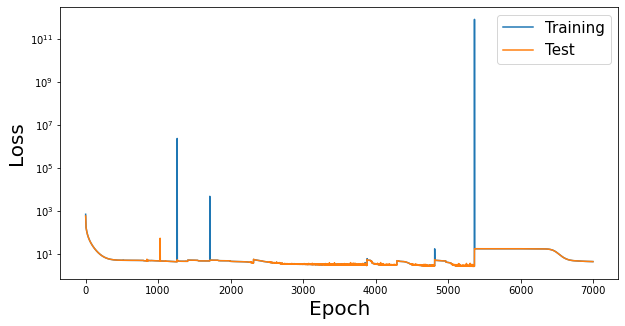

In [44]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Test')

plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend(fontsize=15)
plt.yscale('log')

plt.savefig('LossvsEpoch11.png',dpi = 500)
plt.show()

In [59]:
# Predicciones del modelo
y_test = model11.predict(X11)
y_testT = model11.predict(XT)

292/292 [==============================] - 1s 2ms/step


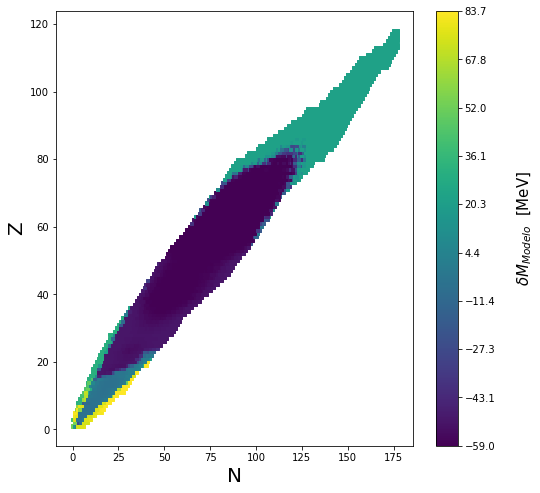

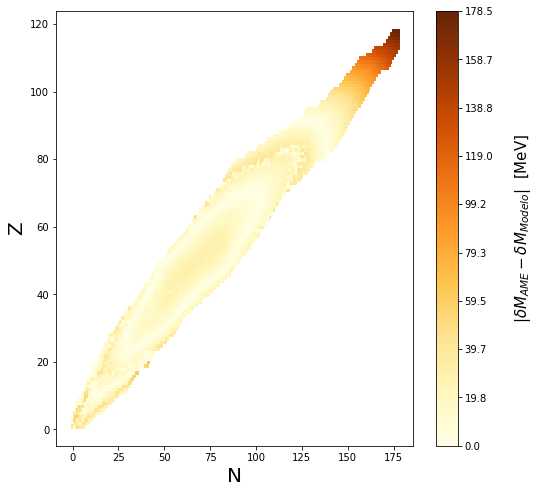

In [46]:
# Valores medios

# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2],X11[:,1], c = y_test[:,0].reshape(5826,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test[:,0].reshape(5826,-1)),max(y_test[:,0].reshape(5826,-1)),10)).set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNPREDmean.png',dpi = 500)
plt.show()

# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2],X11[:,1], c = abs(y_test[:,0].reshape(5826,-1)-Y11), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(abs(y_test[:,0].reshape(5826,-1)-Y11)),max(abs(y_test[:,0].reshape(5826,-1)-Y11)),10)).set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNDIFFmean.png',dpi = 500)
plt.show()

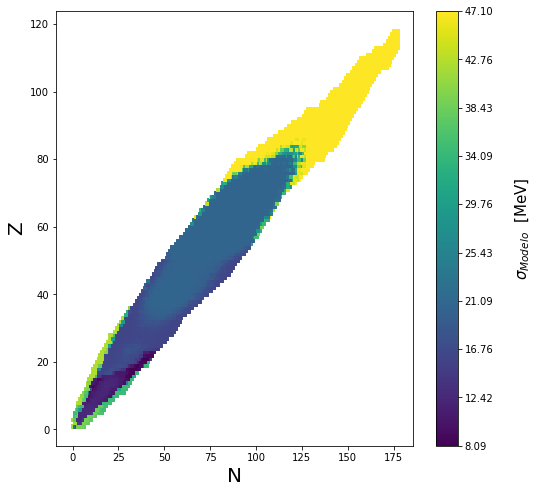

In [60]:
# Desviaciones estándar del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2],X11[:,1], c = y_test[:,1].reshape(5826,-1), s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar(ticks=np.linspace(min(y_test[:,1].reshape(5826,-1)),max(y_test[:,1].reshape(5826,-1)),10)).set_label(label='$\sigma_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11MDNPREDsigma.png',dpi = 500)
plt.show()

In [47]:
print("RMS del modelo: ", RMS(Y11 , y_test[:,0].reshape(5826,-1))[0], 'MeV')

RMS del modelo:  32.531384938683814 MeV


While such MLE-based algorithms are successful in a variety of applications where the
input-output mapping is deterministic, they struggle to learn input-output mappings
that are strongly probabilistic. Such situations are often encountered in nuclear physics
-and data science more widely - where each measurement has an associated uncertainty
(as well as discrepancies between measurements), and the machine learning methods
that are typically discussed in nuclear physics such as Gaussian processes and Bayesian
neural networks have shortcomings, as discussed in the introduction.

\n\n



While many
other machine learning techniques provide only a mean value and variance of the mean,
the MDN provides a unique advantage since it estimates the full posterior distribution,
instead of having to assume a shape for this distribution